# Data Prep

In [1]:
# Import modules, define directories
import pygris
import pandas as pd
import geopandas as gpd
from pygris.utils import shift_geometry
from pygris.data import get_census
from pygris import counties
from pyhere import here
import numpy as np
import libpysal as lps
import lxml
import tabulate

pd.set_option("chained_assignment", None)

path = {
    "dscr": here("data", "scratch"),
    "drpub": here("data", "raw", "public", "spielman", "input"),
    "drpriv": here("data", "raw", "private"),
    "ddpub": here("data", "derived", "public"),
    "ddpriv": here("data", "derived", "private"),
    "rfig": here("results", "figures"),
    "roth": here("results", "other"),
    "rtab": here("results", "tables")
}

### Retrieving Census Data

In [2]:
# Record raw variable names for Spielman et al's data and our own
acs_variables = [
    "B01002_001E", # median age
    "B03002_001E", # total population of respondents to race/ethnicity
    "B03002_004E", # total black
    "B03002_005E", # total native american
    "B03002_006E", # total asian
    "B03002_012E", # total latinx
    "B06001_002E", # total under 5
    "B09020_001E", # total above 65 
    "B01003_001E", # total population 
    "B25008_001E", # total population in occupied housing units
    "B25002_002E", # total occupied housing units 
    "B25003_003E", # total renter occupied housing units
    "B25002_001E", # total housing units for which occupancy status is known
    "B09020_021E", # total 65+ living in group quarters
    "B01001_026E", # total female
    "B11001_006E", # total female-headed family households
    "B11001_001E", # total households (denominator for pct female-headed)
    "B25002_003E", # total vacant housing units
    "B19025_001E", # aggregate household income
    
#     "B16004_029E", # total speak spanish, speak english not well ages 18-64
#     "B16004_030E", # total speak spanish, speak english not at all ages 18-64
#     "B16004_034E", # total speak other indo-european languages, speak english not well ages 18-64
#     "B16004_035E", # total speak other indo-european languages, speak english not at all ages 18-64
#     "B16004_039E", # total speak asian languages, speak english not well ages 18-64
#     "B16004_040E", # total speak asian languages, speak english not at all ages 18-64
#     "B16004_044E", # total speak other languages, speak english not well ages 18-64
#     "B16004_045E", # total speak other languages, speak english not at all ages 18-64
#     "B16004_051E", # total speak spanish, speak english not well ages 65+
#     "B16004_052E", # total speak spanish, speak english not at all ages 65+
#     "B16004_056E", # total speak other indo-european languages, speak english not well ages 65+
#     "B16004_057E", # total speak other indo-european languages, speak english not at all ages 65+
#     "B16004_061E", # total speak asian languages, speak english not well ages 65+
#     "B16004_062E", # total speak asian languages, speak english not at all ages 65+
#     "B16004_066E", # total speak other languages, speak english not well ages 65+
#     "B16004_067E", # total speak other languages, speak english not at all ages 65+
#     "B16004_024E", # total ages 18-64 for language category
#     "B16004_046E", # total 65+ for language category
#     "B16004_025E", # total ages 18-64 that speak only english
#     "B16004_047E", # total 65+ that speak only english
    
    "B23022_025E", # total male unemployed for last 12 months
    "B23022_049E", # total female unemployed for last 12 months
    "B23022_001E", # total for unemployment by sex stats
    "B17021_002E", # total pop below poverty level
    "B17021_001E", # total pop for which poverty info available 
    "B25024_010E", # number of mobile home housing units in structure
    "B25024_001E", # total units in structure
    
    # "B15002_003E", # total male no schooling completed
    # "B15002_004E", # total male nursery to 4th grade
    # "B15002_005E", # total male 5th and 6th grade
    # "B15002_006E", # total male 7th and 8th grade
    # "B15002_007E", # total male 9th grade
    # "B15002_008E", # total male 10th grade
    # "B15002_009E", # total male 11th grade
    # "B15002_010E", # total male 12th grade, no diploma
    # "B15002_020E", # total female no schooling completed
    # "B15002_021E", # total female nursery to 4th grade
    # "B15002_022E", # total female 5th and 6th grade
    # "B15002_023E", # total female 7th and 8th grade
    # "B15002_024E", # total female 9th grade
    # "B15002_025E", # total female 10th grade
    # "B15002_026E", # total female 11th grade
    # "B15002_027E", # total female 12th grade, no diploma
    # "B15002_001E", # total sex by educational attainment (denominator for education)
    
    "C24010_038E", # total female employed
    "C24010_001E", # total for which sex and occupation known
    
#     "C24030_003E", # total male extractive industries
#     "C24030_030E", # total female extractive industries
#     "C24030_001E", # total for which sex and industry known
#     "C24010_019E", # total male in service occupations
#     "C24010_055E", # total female in service occupations
    
    "B19055_002E", # total households with social security income
    "B19055_001E", # total households for which social security income status known
    
    # "B25044_003E", # total owner occupied no vehicle available
    # "B25044_010E", # total rental occupied no vehicle available
    # "B25044_001E", # total for which tenure by vehicle available known
    
    "B09002_002E", # total children in married couple families
    "B09002_001E", # total children by family type and age
    "B19001_017E", # total households over 200k income
    
#    "B11001_001E", # total households (denominator -- is there an alternative from same category? B19001_001E?)
    
    "B06007_005E", # total speak spanish, speak english less than very well
    "B06007_008E", # total speak another language, speak english less than very well
    "B06007_001E", # total speak another language 
    "B16010_002E", # total less than high school
    "B16010_001E", # total for which education, employment, language at home known 
    "C24050_002E", # total in extractive industries
    "C24050_001E", # total for which industry known 
    "C24050_029E", # total in service occupations
    "B08201_002E", # total households no vehicle available
    "B08201_001E", # total households for which vehicle status and family size known 
    "B25064_001E", # median gross rent
    "B25077_001E"  # median home value
]
    
spielman_acs_variables = [
    "ACS12_5yr_B01002001", # median age
    "ACS12_5yr_B03002001", # total population (demoninator for race)
    "ACS12_5yr_B03002004", # total black
    "ACS12_5yr_B03002005", # total native american
    "ACS12_5yr_B03002006", # total asian
    "ACS12_5yr_B03002012", # total latinx
    "ACS12_5yr_B06001002", # total under 5 
    "ACS12_5yr_B09020001", # total above 65 -- they got from different section than under 5. Try summing B06001_011E + B06001_012E and see if result is equivalent?
    "ACS12_5yr_B01003001", # total population (denominator for age, sex) -- check if this is the best denominator for age
    "ACS12_5yr_B25008001", # total population in occupied housing units?
    "ACS12_5yr_B25002002", # total occupied housing units? Believe they divide B25008_001E/B25002_002E to get people per 
    "ACS12_5yr_B25003003", # total renter occupied housing units?
    "ACS12_5yr_B25002001", # total housing units for which occupancy status is known?
    "ACS12_5yr_B09020021", # total 65+ living in group quarters
    "ACS12_5yr_B01001026", # total female
    "ACS12_5yr_B11001006", # total female-headed family households
    "ACS12_5yr_B11001001", # total households (denominator for pct female-headed)
    "ACS12_5yr_B25002003", # total vacant housing units?
    "ACS12_5yr_B19025001", # aggregate household income
    
#     "ACS12_5yr_B16004029", # total speak spanish, speak english not well ages 18-64
#     "ACS12_5yr_B16004030", # total speak spanish, speak english not at all ages 18-64
#     "ACS12_5yr_B16004034", # total speak other indo-european languages, speak english not well ages 18-64
#     "ACS12_5yr_B16004035", # total speak other indo-european languages, speak english not at all ages 18-64
#     "ACS12_5yr_B16004039", # total speak asian languages, speak english not well ages 18-64
#     "ACS12_5yr_B16004040", # total speak asian languages, speak english not at all ages 18-64
#     "ACS12_5yr_B16004044", # total speak other languages, speak english not well ages 18-64
#     "ACS12_5yr_B16004045", # total speak other languages, speak english not at all ages 18-64
#     "ACS12_5yr_B16004051", # total speak spanish, speak english not well ages 65+
#     "ACS12_5yr_B16004052", # total speak spanish, speak english not at all ages 65+
#     "ACS12_5yr_B16004056", # total speak other indo-european languages, speak english not well ages 65+
#     "ACS12_5yr_B16004057", # total speak other indo-european languages, speak english not at all ages 65+
#     "ACS12_5yr_B16004061", # total speak asian languages, speak english not well ages 65+
#     "ACS12_5yr_B16004062", # total speak asian languages, speak english not at all ages 65+
#     "ACS12_5yr_B16004066", # total speak other languages, speak english not well ages 65+
#     "ACS12_5yr_B16004067", # total speak other languages, speak english not at all ages 65+
#     "ACS12_5yr_B16004024", # total ages 18-64 for language category
#     "ACS12_5yr_B16004046", # total 65+ for language category
#     "ACS12_5yr_B16004025", # total ages 18-64 that speak only english
#     "ACS12_5yr_B16004047", # total 65+ that speak only english
    
    "ACS12_5yr_B23022025", # total male unemployed for last 12 months -- did they not have the stat available without the male/female cross tabulation?
    "ACS12_5yr_B23022049", # total female unemployed for last 12 months
    "ACS12_5yr_B23022001", # total for unemployment by sex stats
    "ACS12_5yr_B17021002", # total pop below poverty level
    "ACS12_5yr_B17021001", # total pop for which poverty info available (denominator for poverty pct)
    "ACS12_5yr_B25024010", # number of mobile home housing units in structure
    "ACS12_5yr_B25024001", # total units in structure
    
    # "ACS12_5yr_B15002003", # total male no schooling completed
    # "ACS12_5yr_B15002004", # total male nursery to 4th grade
    # "ACS12_5yr_B15002005", # total male 5th and 6th grade
    # "ACS12_5yr_B15002006", # total male 7th and 8th grade
    # "ACS12_5yr_B15002007", # total male 9th grade
    # "ACS12_5yr_B15002008", # total male 10th grade
    # "ACS12_5yr_B15002009", # total male 11th grade
    # "ACS12_5yr_B15002010", # total male 12th grade, no diploma
    # "ACS12_5yr_B15002020", # total female no schooling completed
    # "ACS12_5yr_B15002021", # total female nursery to 4th grade
    # "ACS12_5yr_B15002022", # total female 5th and 6th grade
    # "ACS12_5yr_B15002023", # total female 7th and 8th grade
    # "ACS12_5yr_B15002024", # total female 9th grade
    # "ACS12_5yr_B15002025", # total female 10th grade
    # "ACS12_5yr_B15002026", # total female 11th grade
    # "ACS12_5yr_B15002027", # total female 12th grade, no diploma
    # "ACS12_5yr_B15002001", # total sex by educational attainment (denominator for education)
    
    "ACS12_5yr_C24010038", # total female employed
    "ACS12_5yr_C24010001", # total for which sex and occupation -- including employment status -- known (a denominator)
    
    # "ACS12_5yr_C24030003", # total male extractive industries
    # "ACS12_5yr_C24030030", # total female extractive industries
    # "ACS12_5yr_C24030001", # total for which sex and industry known
    # "ACS12_5yr_C24010019", # total male in service occupations
    # "ACS12_5yr_C24010055", # total female in service occupations
    
    "ACS12_5yr_B19055002", # total households(?) with social security income
    "ACS12_5yr_B19055001", # total households(?) for which social security income status known
    
    # "ACS12_5yr_B25044003", # total owner occupied no vehicle available
    # "ACS12_5yr_B25044010", # total rental occupied no vehicle available
    # "ACS12_5yr_B25044001", # total for which tenure by vehicle available known
    
    "ACS12_5yr_B09002002", # total children in married couple families
    "ACS12_5yr_B09002001", # total children by family type and age (a denominator)
    "ACS12_5yr_B19001017", # total households over 200k income
    
    # "ACS12_5yr_B11001001", # total households (denominator -- is there an alternative from same category? B19001_001E?)
    
    "ACS12_5yr_B06007005", # total speak spanish, speak english less than very well
    "ACS12_5yr_B06007008", # total speak another language, speak english less than very well
    "ACS12_5yr_B06007001", # total speak another language (a denominator)
    "ACS12_5yr_B16010002", # total less than high school
    "ACS12_5yr_B16010001", # total for which education, employment, language at home known (a denominator)
    "ACS12_5yr_C24050002", # total in extractive industries
    "ACS12_5yr_C24050001", # total for which industry known (a denominator)
    "ACS12_5yr_C24050029", # total in service occupations
    "ACS12_5yr_B08201002", # total households no vehicle available
    "ACS12_5yr_B08201001", # total households for which vehicle status and family size known (a denominator)
    "ACS12_5yr_B25064001", # median gross rent
    "ACS12_5yr_B25077001", # median value (of what? housing?)
]
    
# looks like they calculate some things in a slightly slower way and then recalculate them with fewer vars
# I've commented out the variables that we don't actually need, as well as the less-efficient calculations using these vars

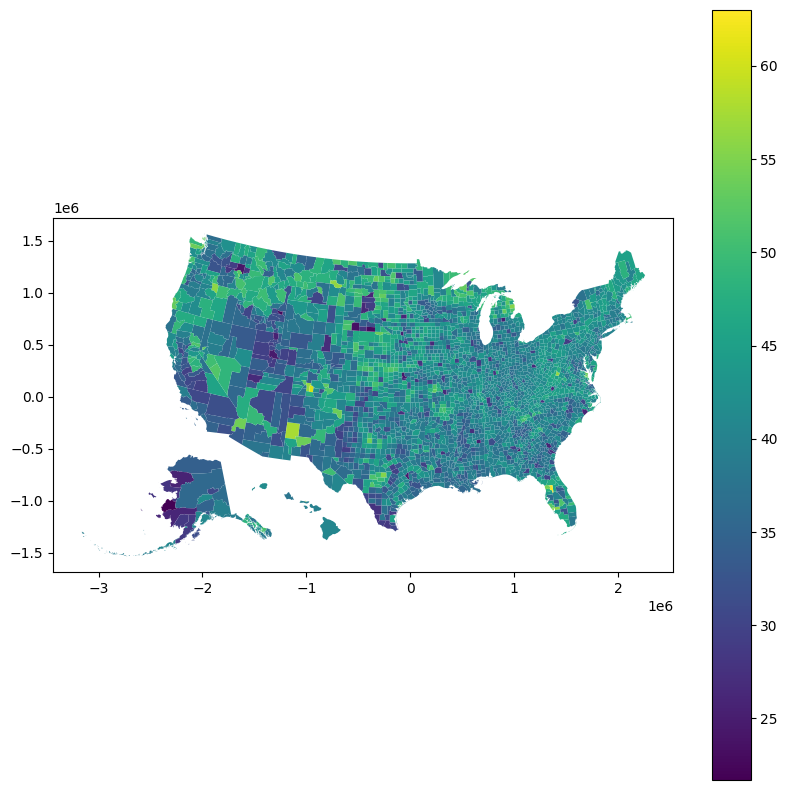

In [3]:
# Obtain our data from the census using pygris

# Acquire attribute data
counties_detailed = get_census(dataset = "acs/acs5", # dataset name on the Census API you are connecting to; find datasets at https://api.census.gov/data.html
                        variables = acs_variables, # string (or list of strings) of desired vars. For the 2021 5-year ACS Data Profile, those variable IDs are found at https://api.census.gov/data/2021/acs/acs5/profile/variables.html
                        year = 2012, # year of your data (or end-year for a 5-year ACS sample)
                        params = { # dict of query parameters to send to the API.
                          "for": "county:*"},#,
                          # "in": "state:36"},
                        guess_dtypes = True,
                        return_geoid = True)

# Acquire geographical data
counties_shp = counties(cb = True, year = 2010, cache = True) # year 2012 (and 2011) cartographic boundaries not available
counties_shp['GEOID'] = counties_shp.STATE + counties_shp.COUNTY
counties_shp['CENSUSAREA_check'] = counties_shp.CENSUSAREA.round(0)

# Join the data and map it
counties = counties_shp.merge(counties_detailed, how = "inner", on = "GEOID")
counties = counties[counties.STATE != '72']
counties_pretty = shift_geometry(counties)
counties_pretty.plot(column = "B01002_001E", legend = True, figsize = (10, 10)); # believe plot() from gpd

In [4]:
# Define a function that can determine whether every entry in specified columns of two tables match  
def equiv(table1, sort1, column1, table2, sort2, column2):
    ''' 
    Tests two tables to see whether corresponding columns have equivalent entries.
    
    Parameters:
    table1 - the first table
    sort1 - the column in the first table to join by (str)
    column1 - the column(s) in the first table to test the values of (list of str) (should list analogous columns for columns2) 
    table2 - the second table
    sort2 - the column in the second table to join by (str)
    column2 - the column(s) in the second table to test the values of (list of str)
    '''
    # Sort tables
    table1 = table1.sort_values(by = sort1).reset_index()
    table2 = table2.sort_values(by = sort2).reset_index()
    
    # Rename column name in table2 to match that in table1
    for i in range(len(column1)):
        table2 = table2.rename(columns={column2[i]: column1[i]})

    # Select the columns to test equivalency of
    table1 = table1[column1]
    table2 = table2[column1]
    
    # Perform equivalency test
    test = table1.eq(table2)
    return test

In [5]:
%%script echo skipping # Cell magic to not run this code chunk

# A toy example to illustrate how the function works

# Create two DataFrames from dictionaries
data1 = {
    "id": [1,2,3],
    "calories": [420, 380, 390],
    "duration": [50, 40, 45]
}

data1 = pd.DataFrame(data1)

data2 = {
    "identifier": [1,2,3],
    "caloriesayy": [420, 380, 390],
    "durationyayy": [50, 40, 0]
}

data2 = pd.DataFrame(data2)

# Perform equivalency test
test = equiv(data1, "id", ["calories", "duration"], data2, "identifier", ["caloriesayy", "durationyayy"])
test#.sum() # optionally use .sum() to determine how many entries match

skipping # Cell magic to not run this code chunk


In [6]:
# Import raw data from Spielman et al

# Import base ACS data
make_strings = {'Geo_FIPS': object, 'Geo_STATE': object, 'Geo_COUNTY': object,
                'Geo_TRACT': object, 'Geo_CBSA': object, 'Geo_CSA': object}

acs = pd.read_csv(here(path["drpub"], 'sovi_acs.csv'),
                  dtype=make_strings, skiprows=1,encoding='latin-1')

# Import, join a decennial supplemental
dec_sup1 = pd.read_csv(here(path["drpub"],'sovi_decennial_sup1.csv'),
        dtype=make_strings,skiprows=1,encoding='latin-1')

acs = acs.merge(dec_sup1, how = "inner", on='Geo_FIPS')

# Import, join an ACS supplemental
acs_sup2 = pd.read_csv(here(path["drpub"], 'sovi_acs_kids.csv'),
                           dtype=make_strings, skiprows=1,encoding='latin-1')

acs = acs.merge(acs_sup2, how = "inner", on='Geo_FIPS')

# Round area column
acs['SE_T02A_002_check'] = acs.SE_T02A_002.round(0)

# Drop Puerto Rico to avoid issues with missing data
acs = acs[acs.Geo_STATE_x != '72'] 

In [7]:
# Add the area variables to the lists of variables
acs_variables.append('CENSUSAREA_check')
spielman_acs_variables.append('SE_T02A_002_check')

In [8]:
# Perform equivalency test
test = equiv(counties, "GEOID", acs_variables, acs, "Geo_FIPS", spielman_acs_variables)
matching_cols = pd.DataFrame({"test": test.sum().eq(3143)}) # 3143 matches the number of rows (3221 if PR included)
matching_cols.loc[~matching_cols.test] # Identify the columns that have some data discrepencies

,test
B25077_001E,False
CENSUSAREA_check,False


The following variables have some discrepancy between their dataset and mine:
- B25077_001E
- CENSUSAREA

Sidenote: because we removed Puerto Rico from the analysis, we eliminated discrepancies (due to NAs) due to these variables:
- B06001_002E
- B06007_005E
- B06007_008E
- B06007_001E


In [9]:
# Show the rows for which there are data discrepancies (false means discrepancy)
messed_up_indices = test[["CENSUSAREA_check", "B25077_001E"]].loc[~test.CENSUSAREA_check |~test.B25077_001E]
messed_up_indices

,CENSUSAREA_check,B25077_001E
471,False,True
548,True,False
673,False,True
2087,False,True


In [10]:
# Inspect the data values at the indices that are mis-matched

# Select the data of interest from tygris
tygris_data = counties.sort_values(by = "GEOID")\
    .reset_index().loc[messed_up_indices.index]\
    [["GEOID", "CENSUSAREA", "CENSUSAREA_check", "B25077_001E"]]

# Select the data of interest from Spielman et al
spielman_data = acs.sort_values(by = "Geo_FIPS")\
    .reset_index().loc[messed_up_indices.index]\
    [["Geo_FIPS", "SE_T02A_002", "SE_T02A_002_check", "ACS12_5yr_B25077001"]]

# Join and inspect
merged = tygris_data.merge(spielman_data, how = "inner", left_on = "GEOID", right_on = "Geo_FIPS")
merged

,GEOID,CENSUSAREA,CENSUSAREA_check,B25077_001E,Geo_FIPS,SE_T02A_002,SE_T02A_002_check,ACS12_5yr_B25077001
0,13171,183.500,184.0,119800.0,13171,183.49990,183.0,119800.0
1,15005,11.991,12.0,NaN,15005,11.99148,12.0,NaN
2,17157,575.500,576.0,89300.0,17157,575.49980,575.0,89300.0
3,39089,682.500,682.0,151300.0,39089,682.50010,683.0,151300.0


By inspection, we see that the one disagreement between B25077_001E and ACS12_5yr_B25077001 occurs because of a NaN value in an analogous location in each of the two datasets.

We also see that in the 3 cases where we have a disagreement between CENSUSAREA and SE_T02A_002, the two values differ only by 1 (this variable was rounded to the 1's place). This minor discrepancy is unlikely to influence our results.

Thus, our data sufficiently matches Spielman et al's. Also, this shows us that we need to impute a missing value for one NaN in B25077_001E.

### Calculating Variables to Use in PCA

In [11]:
# Check for missing data
for i in counties.columns:
    x = counties[i].isnull().sum()
    if x > 0:
        print(i, x)
        
# Check for infinities
counties_num = counties.select_dtypes(include=['int64','float64'])
for i in counties_num.columns:
    xmin = counties_num[i].min()
    xmax = counties_num[i].max()
    if xmin == -np.inf:
        print(i, "contains a negative infinity")
    elif xmax == np.inf:
        print(i, "contains a positive infinity")

LSAD 2
B25077_001E 1


Of the two variables with missing data, we only use one of them -- B25077_001E -- to calculate our variables for PCA.

In [12]:
# Calculating the variables used in SoVI

# Note: Spielman et al calculated a few variables twice in different ways.
# I include the one they actually use in their model, commenting out the alternative.
# I also comment out imputation from their paper that seems unnecessary based on what I found above.
counties['MEDAGE_ACS'] = counties.B01002_001E
counties['BLACK_ACS'] = counties.B03002_004E / (counties.B03002_001E)
counties['QNATAM_ACS'] = counties.B03002_005E / (counties.B03002_001E)
counties['QASIAN_ACS'] = counties.B03002_006E / (counties.B03002_001E)
counties['QHISP_ACS'] = counties.B03002_012E / (counties.B03002_001E)
counties['QAGEDEP_ACS'] = (counties.B06001_002E + counties.B09020_001E) / (counties.B01003_001E)
# for "B09020_001E" -- total above 65 -- they got from different section than under 5. Try summing B06001_011E + B06001_012E instead?
counties['QPUNIT_ACS'] = counties.B25008_001E / (counties.B25002_002E)
counties['PRENTER_ACS'] = counties.B25003_003E / (counties.B25002_001E)
counties['QNRRES_ACS'] = counties.B09020_021E / (counties.B01003_001E)
counties['QFEMALE_ACS'] = counties.B01001_026E / (counties.B01003_001E)
counties['QFHH_ACS'] = counties.B11001_006E / (counties.B11001_001E)
counties['QUNOCCHU_ACS'] = counties.B25002_003E / (counties.B25002_001E)
# counties['PERCAP'] = counties.B19025_001E / (counties.B01003_001E) # PERCAP 1
# counties['QESL'] = (counties.B16004_029E + counties.B16004_030E +  # QESL 1
#                 counties.B16004_034E + counties.B16004_035E +
#                 counties.B16004_039E + counties.B16004_040E +
#                 counties.B16004_044E + counties.B16004_045E +
#                 counties.B16004_051E + counties.B16004_052E +
#                 counties.B16004_056E + counties.B16004_057E +
#                 counties.B16004_061E + counties.B16004_062E +
#                 counties.B16004_066E + counties.B16004_067E) / \
#               ((counties.B16004_024E + counties.B16004_046E) - (counties.B16004_025E + counties.B16004_047E))
# Imputation that seems unnecessary
# counties.QESL = counties.QESL.replace([np.inf, -np.inf, np.nan], 0)
# counties.QESL = counties.QESL.replace([np.inf, -np.inf], 0)
counties['QCVLUN'] = (counties.B23022_025E + counties.B23022_049E) / \
                counties.B23022_001E
# For "B23022_025E" -- total male unemployed for last 12 months -- did they not have the stat available without the male/female cross tabulation?

counties['QPOVTY'] = (counties.B17021_002E) / counties.B17021_001E
counties['QMOHO'] = (counties.B25024_010E) / counties.B25024_001E
# counties['QED12LES'] = (counties.B15002_003E + counties.B15002_004E + # QED 1
#                     counties.B15002_005E + counties.B15002_006E +
#                     counties.B15002_007E + counties.B15002_008E +
#                     counties.B15002_009E + counties.B15002_010E +
#                     counties.B15002_020E + counties.B15002_021E +
#                     counties.B15002_022E + counties.B15002_023E +
#                     counties.B15002_024E + counties.B15002_025E +
#                     counties.B15002_026E + counties.B15002_027E) / \
#                     counties.B15002_001E
counties['QFEMLBR'] = (counties.C24010_038E) / counties.C24010_001E
# counties['QEXTRCT'] = (counties.C24030_003E + counties.C24030_030E) / \ # QEXTRCT 1
#                  counties.C24030_001E
# counties['QSERV'] = (counties.C24010_019E + counties.C24010_055E) / \ # QSERV 1
#                counties.C24010_001E
counties['QSSBEN'] = (counties.B19055_002E) / counties.B19055_001E
# counties['QNOAUTO'] = (counties.B25044_003E + counties.B25044_010E) / \ # NO AUTO 1
#                  counties.B25044_001E
counties['QFAM'] = (counties.B09002_002E) / counties.B09002_001E
counties.QFAM = counties.QFAM.replace([np.inf, -np.inf, np.nan], 0) # this is new -- i missed this the first time around
# Seemingly unnecessary imputation
# counties.QFAM = counties.QFAM.replace([np.inf, -np.inf, np.nan], 0)
counties['QRICH200K'] = (counties.B19001_017E) / counties.B11001_001E # would B19001_001E be a better denominator?
counties['PERCAP_ALT'] = counties.B19025_001E / (counties.B25008_001E) 
counties['QESL_ALT'] = (counties.B06007_005E + counties.B06007_008E) / \
                  counties.B06007_001E
counties['QED12LES_ALT'] = (counties.B16010_002E) / counties.B16010_001E 
counties['QEXTRCT_ALT'] = (counties.C24050_002E) / counties.C24050_001E 
counties['QSERV_ALT'] = (counties.C24050_029E) / counties.C24050_001E 
counties['QNOAUTO_ALT'] = (counties.B08201_002E) / counties.B08201_001E 
counties['MDGRENT_ALT'] = counties.B25064_001E # they originally determined the median by hand
counties['MHSEVAL_ALT'] = counties.B25077_001E # they originally determined the median by hand
counties['POPDENS'] = counties.B01003_001E / (counties.CENSUSAREA)

### Imputing spatial lag for the one NaN

In [13]:
# The idea is to assign the spatial lag of the estimate and SE to any missing median home values

# Spielman Data
gdf = gpd.read_file(here(path["drpub"], 'USA_Counties_500k.shp')) # Read in Spielman et al's shapefile

w = lps.weights.Queen.from_dataframe(gdf) # Calculate spatial weights matrix

w.transform = 'R'

gdf['GEOID'] = gdf.STATE + gdf.COUNTY
gdf = gdf.merge(acs, how = "inner", left_on = 'GEOID', right_on = "Geo_FIPS")

gdf['MHSEVAL_ALT_LAG'] = lps.weights.lag_spatial(w, gdf.ACS12_5yr_B25077001)

# Pygris Data
w2 = lps.weights.Queen.from_dataframe(counties) # Calculate spatial weights matrix

w2.transform = 'R'

counties['MHSEVAL_ALT_LAG'] = lps.weights.lag_spatial(w2, counties.MHSEVAL_ALT)

# Equivalence test
test = equiv(gdf, "GEOID", ["MHSEVAL_ALT_LAG"], counties, "GEOID", ["MHSEVAL_ALT_LAG"])
test.sum().eq(3143)

/Users/liamsmith/opt/anaconda3/envs/RPl-Spielman-2020/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 10 disconnected components.
 There are 7 islands with ids: 68, 546, 547, 549, 1226, 1876, 2976.
  warnings.warn(message)


('WARNING: ', 68, ' is an island (no neighbors)')
('WARNING: ', 546, ' is an island (no neighbors)')
('WARNING: ', 547, ' is an island (no neighbors)')
('WARNING: ', 549, ' is an island (no neighbors)')
('WARNING: ', 1226, ' is an island (no neighbors)')
('WARNING: ', 1876, ' is an island (no neighbors)')
('WARNING: ', 2976, ' is an island (no neighbors)')
('WARNING: ', 68, ' is an island (no neighbors)')
('WARNING: ', 546, ' is an island (no neighbors)')
('WARNING: ', 547, ' is an island (no neighbors)')
('WARNING: ', 549, ' is an island (no neighbors)')
('WARNING: ', 1226, ' is an island (no neighbors)')
('WARNING: ', 1876, ' is an island (no neighbors)')
('WARNING: ', 2976, ' is an island (no neighbors)')


/Users/liamsmith/opt/anaconda3/envs/RPl-Spielman-2020/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 10 disconnected components.
 There are 7 islands with ids: 68, 546, 547, 549, 1226, 1876, 2976.
  warnings.warn(message)


MHSEVAL_ALT_LAG    False
dtype: bool

In [14]:
# Show the indices of any values that do not match
messed_up_indices = test[["MHSEVAL_ALT_LAG"]].loc[~test.MHSEVAL_ALT_LAG]
messed_up_indices

,MHSEVAL_ALT_LAG
550,False


In [15]:
# Check the values of the one non-matching index
print(gdf["MHSEVAL_ALT_LAG"][550], counties["MHSEVAL_ALT_LAG"][550])

nan nan


Okay great they're just missing data so they're identical! And we don't care about the missing spatial lag, because that county already has a value for MHSEVAL_ALT.

In [16]:
# Issues in Hawaii
counties.iloc[[548, 550]]
# 548 is the one with missing median home value
# 550 is the one with missing spatial lag

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,GEOID,CENSUSAREA_check,B01002_001E,...,PERCAP_ALT,QESL_ALT,QED12LES_ALT,QEXTRCT_ALT,QSERV_ALT,QNOAUTO_ALT,MDGRENT_ALT,MHSEVAL_ALT,POPDENS,MHSEVAL_ALT_LAG
548,0500000US15005,15,005,Kalawao,County,11.991,"POLYGON ((-157.01455 21.18550, -156.99911 21.1...",15005,12.0,58.4,...,51796.774194,0.090909,0.076923,0.000000,0.074074,0.041667,438,NaN,5.504128,563500.0
550,0500000US15009,15,009,Maui,County,1161.521,"MULTIPOLYGON (((-157.06121 20.89150, -157.0625...",15009,1162.0,39.5,...,28608.235649,0.093689,0.102753,0.027283,0.274424,0.053208,1293,563500.0,133.391475,NaN


In [17]:
# Impute for the missing value
counties.MHSEVAL_ALT[np.isnan(counties['MHSEVAL_ALT'])] = counties[["MHSEVAL_ALT_LAG"]][pd.isna(counties['MHSEVAL_ALT'])]

In [18]:
# A look at the state causing the issue of the missing spatial lag (islands in Hawaii)
counties.loc[counties['STATE'] == "15"].explore(column = "MHSEVAL_ALT", 
                                                cmap = "RdPu",
                                                tooltip = ["COUNTY", "MHSEVAL_ALT"],
                                                # tiles = "CartoDB positron",
                                                tooltip_kwds = dict(aliases = ["County", "Median Home Value"]),
                                                legend_kwds = dict(caption = "Median Home Value"))

In [19]:
counties.iloc[:,-29:-1]

,MEDAGE_ACS,BLACK_ACS,QNATAM_ACS,QASIAN_ACS,QHISP_ACS,QAGEDEP_ACS,QPUNIT_ACS,PRENTER_ACS,QNRRES_ACS,QFEMALE_ACS,...,QRICH200K,PERCAP_ALT,QESL_ALT,QED12LES_ALT,QEXTRCT_ALT,QSERV_ALT,QNOAUTO_ALT,MDGRENT_ALT,MHSEVAL_ALT,POPDENS
0,41.2,0.038443,0.002013,0.000000,0.021000,0.225629,2.672526,0.175514,0.003489,0.508420,...,0.013773,18646.090730,0.008884,0.257741,0.048569,0.158657,0.063791,566,91300.0,26.611319
1,37.8,0.171697,0.006645,0.012168,0.061442,0.213285,2.593359,0.247945,0.005824,0.506144,...,0.015946,22821.538586,0.034113,0.182346,0.032847,0.155959,0.066835,638,126400.0,73.590664
2,44.4,0.314728,0.000619,0.000000,0.019903,0.218841,2.406735,0.114909,0.002831,0.490402,...,0.001531,18845.457023,0.006690,0.242119,0.029628,0.165825,0.046578,573,74500.0,17.367566
3,42.5,0.125493,0.005370,0.003069,0.013650,0.248287,2.501309,0.200786,0.006878,0.515250,...,0.013021,19604.360426,0.009961,0.226478,0.064493,0.155167,0.066179,560,86700.0,36.685700
4,40.3,0.221817,0.005297,0.015246,0.015246,0.223964,2.442635,0.235687,0.008518,0.512633,...,0.019653,20929.515802,0.020430,0.236889,0.082556,0.140193,0.060907,488,70000.0,22.946915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,44.5,0.008475,0.003632,0.003632,0.022195,0.217111,2.237907,0.260090,0.000000,0.550040,...,0.021718,25329.819144,0.002096,0.099049,0.255245,0.178322,0.059230,557,122900.0,0.943627
3139,47.8,0.000115,0.001152,0.000461,0.068111,0.263340,2.341617,0.160592,0.005417,0.493604,...,0.008465,24646.658892,0.014518,0.099858,0.156718,0.212128,0.039869,519,133300.0,4.163212
3140,32.9,0.004352,0.001732,0.005286,0.151606,0.166781,2.613124,0.254671,0.002620,0.478218,...,0.033928,30858.410480,0.043683,0.097158,0.185796,0.151213,0.032235,881,174600.0,4.209406
3141,41.6,0.003561,0.003561,0.002849,0.136973,0.241424,2.400116,0.275582,0.006766,0.495786,...,0.026461,26024.485098,0.031984,0.092084,0.127079,0.167287,0.045944,511,157700.0,3.763599


In [20]:
pd.options.display.max_columns = 30

In [21]:
# Generate descriptive statistics for each variable
counties.iloc[:,-29:-1].describe(include = np.number)

,MEDAGE_ACS,BLACK_ACS,QNATAM_ACS,QASIAN_ACS,QHISP_ACS,QAGEDEP_ACS,QPUNIT_ACS,PRENTER_ACS,QNRRES_ACS,QFEMALE_ACS,QFHH_ACS,QUNOCCHU_ACS,QCVLUN,QPOVTY,QMOHO,QFEMLBR,QSSBEN,QFAM,QRICH200K,PERCAP_ALT,QESL_ALT,QED12LES_ALT,QEXTRCT_ALT,QSERV_ALT,QNOAUTO_ALT,MDGRENT_ALT,MHSEVAL_ALT,POPDENS
count,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000
mean,40.356920,0.088549,0.017380,0.011531,0.082909,0.222054,2.519315,0.227351,0.007424,0.499996,0.112561,0.176561,0.255724,0.162960,0.131116,0.470559,0.342857,0.704618,0.022606,23491.646174,0.034707,0.158558,0.069062,0.180764,0.065137,668.374483,132077.601018,259.786246
std,5.080661,0.145046,0.073772,0.025510,0.132561,0.037253,0.248643,0.075552,0.005182,0.023898,0.043576,0.104445,0.088042,0.064371,0.093062,0.030273,0.070289,0.102221,0.021643,5613.809138,0.049551,0.070417,0.074635,0.036141,0.045533,186.094360,80948.657969,1732.099102
min,21.700000,0.000000,0.000000,0.000000,0.000000,0.058824,1.291667,0.032531,0.000000,0.235294,0.000000,0.019678,0.022222,0.000000,0.000000,0.184615,0.101917,0.000000,0.000000,7992.487768,0.000000,0.024515,0.000000,0.049057,0.000000,296.000000,19400.000000,0.038741
25%,37.400000,0.004906,0.001145,0.001975,0.015925,0.197918,2.367494,0.177988,0.004133,0.495268,0.084678,0.105447,0.195039,0.116860,0.056782,0.456736,0.297925,0.653277,0.010806,19748.025306,0.007906,0.105641,0.018150,0.157505,0.043710,548.000000,82800.000000,16.874276
50%,40.400000,0.019967,0.002530,0.004945,0.032885,0.218374,2.499270,0.217397,0.006347,0.504616,0.106623,0.147430,0.246190,0.155818,0.112395,0.472986,0.345378,0.713335,0.016941,22886.528921,0.016776,0.144262,0.042591,0.177819,0.058078,622.000000,108000.000000,45.080580
75%,43.300000,0.100831,0.006102,0.010774,0.082828,0.242528,2.632471,0.266206,0.009270,0.511648,0.133354,0.216685,0.307841,0.198231,0.189578,0.487566,0.387539,0.770423,0.026422,26186.803735,0.039430,0.203099,0.091692,0.199096,0.076229,735.000000,154600.000000,113.919660
max,63.000000,0.861940,0.937075,0.431188,0.983246,0.469079,4.696006,0.739922,0.048251,0.576681,0.435490,0.787879,0.715768,0.494535,0.615222,0.634990,0.715502,1.000000,0.232448,61779.174312,0.544021,0.551227,0.588889,0.384312,0.839789,1678.000000,944100.000000,69943.273906


In [22]:
# Save Data
counties.to_file(here(path["ddpub"],'counties.gpkg'))  

In [23]:
counties_pd = pd.DataFrame(counties.drop(columns='geometry'))
counties_pd.to_csv(here(path["ddpub"],'counties.csv'))  

In [24]:
counties_pd.sort_values("GEOID")

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,GEOID,CENSUSAREA_check,B01002_001E,B03002_001E,B03002_004E,B03002_005E,B03002_006E,B03002_012E,B06001_002E,...,QMOHO,QFEMLBR,QSSBEN,QFAM,QRICH200K,PERCAP_ALT,QESL_ALT,QED12LES_ALT,QEXTRCT_ALT,QSERV_ALT,QNOAUTO_ALT,MDGRENT_ALT,MHSEVAL_ALT,POPDENS,MHSEVAL_ALT_LAG
14,0500000US01001,01,001,Autauga,County,594.436,01001,594.0,37.0,54590,9796,157,439,1310,3529.0,...,0.208769,0.471876,0.292766,0.726847,0.020116,24527.541474,0.007834,0.148873,0.014342,0.160870,0.051370,836,137900.0,91.834949,103000.000000
15,0500000US01003,01,003,Baldwin,County,1589.784,01003,1590.0,41.2,183226,16922,995,1347,7915,11218.0,...,0.125789,0.464652,0.356091,0.751875,0.034721,26823.877641,0.025534,0.116224,0.017060,0.178005,0.030817,874,172900.0,115.252135,99200.000000
16,0500000US01005,01,005,Barbour,County,884.876,01005,885.0,38.2,27469,12610,25,56,1365,1578.0,...,0.258293,0.501907,0.371325,0.467056,0.006686,16745.766236,0.026496,0.264092,0.034979,0.166612,0.099756,577,88700.0,31.042768,82662.500000
17,0500000US01007,01,007,Bibb,County,622.582,01007,623.0,39.4,22769,4944,80,25,419,1312.0,...,0.328422,0.418804,0.374763,0.629812,0.003791,16075.803489,0.005965,0.238562,0.015206,0.134649,0.051178,581,91600.0,36.571889,123016.666667
18,0500000US01009,01,009,Blount,County,644.776,01009,645.0,39.1,57466,710,119,97,4646,3620.0,...,0.211986,0.448397,0.370976,0.756860,0.008701,20554.321508,0.042287,0.243366,0.030121,0.139538,0.038324,588,115200.0,89.125526,112366.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3140,0500000US56037,56,037,Sweetwater,County,10426.649,56037,10427.0,32.9,43890,191,76,232,6654,3668.0,...,0.222831,0.407499,0.203145,0.756602,0.033928,30858.410480,0.043683,0.097158,0.185796,0.151213,0.032235,881,174600.0,4.209406,225987.500000
3133,0500000US56039,56,039,Teton,County,3995.379,56039,3995.0,36.6,21326,40,83,116,3107,1244.0,...,0.030107,0.454261,0.181384,0.820168,0.084619,37358.009137,0.084105,0.039269,0.058137,0.228046,0.023611,1072,692700.0,5.337666,208425.000000
3134,0500000US56041,56,041,Uinta,County,2081.264,56041,2081.0,34.3,20942,18,46,9,1816,1725.0,...,0.200666,0.435517,0.226790,0.794320,0.031039,24594.017011,0.025915,0.117354,0.134304,0.185250,0.028142,634,180200.0,10.062155,251875.000000
3141,0500000US56043,56,043,Washakie,County,2238.549,56043,2239.0,41.6,8425,30,30,24,1154,546.0,...,0.095525,0.477041,0.339634,0.790675,0.026461,26024.485098,0.031984,0.092084,0.127079,0.167287,0.045944,511,157700.0,3.763599,175250.000000


In [25]:
%%script echo skipping
pd.options.display.max_rows = 150
missing = pd.DataFrame({"na": counties.isna().sum()})
missing.loc[missing["na"] > 0]

skipping


### Documenting Metadata

In [26]:
var_list = pd.read_html("http://api.census.gov/data/2012/acs/acs5/variables.html")[0]

Future exception was never retrieved
future: <Future finished exception=BrokenPipeError(32, 'Broken pipe')>
Traceback (most recent call last):
  File "/Users/liamsmith/opt/anaconda3/envs/RPl-Spielman-2020/lib/python3.9/asyncio/unix_events.py", line 665, in write
    n = os.write(self._fileno, data)
BrokenPipeError: [Errno 32] Broken pipe


In [27]:
acs_variables.pop()
spielman_acs_variables.pop()

'SE_T02A_002_check'

In [28]:
# Convert list to DataFrame
acs_variables = pd.DataFrame( {"Name": acs_variables} )

# Create spielman labels
acs_variables["Spielman Label"] = spielman_acs_variables

# Manually create alias column
acs_variables["Alias"] = ["median age",
                          "total population of respondents to race/ethnicity",
                          "total Black population",
                          "total Native American population",
                          "total Asian population",
                          "total Latinx population",
                          "total population under 5 years of age",
                          "total population over 65 years of age",
                          "total population",
                          "total population in occupied housing units",
                          "total occupied housing units",
                          "total renter occupied housing units",
                          "total housing units for which occupancy status is known",
                          "total 65+ living in group quarters",
                          "total female population",
                          "total female-headed family households",
                          "total households for which household type is known",
                          "total vacant housing units",
                          "aggregate household income",
                          "total males unemployed for last 12 months",
                          "total females unemployed for last 12 months",
                          "total population for which unemployment and sex cross-tabulations known",
                          "total population below poverty level",
                          "total population for which poverty information available",
                          "number of mobile home housing units in structure",
                          "total housing units in structure",
                          "total female employed",
                          "total population for which sex and occupation known",
                          "total households with social security income",
                          "total households for which social security income status known",
                          "total children in married couple families",
                          "total children for which family type and age are known",
                          "total households with over 200k income",
                          "total Spanish-speakers who speak english less than very well",
                          "total people who speak another language and speak English less than very well",
                          "total population with known language spoken at home and English ability",
                          "total population with less than a high school graduate education",
                          "total for which education, employment, language at home known",
                          "total population in extractive industries",
                          "total population for which industry known",
                          "total people in service occupations",
                          "total households with no available vehicle",
                          "total households for which vehicle status and family size known",
                          "median gross rent",
                          "median home value"]
       
# Join metadata from census website
acs_variables = acs_variables.merge(var_list, on = "Name")[["Name", "Spielman Label", "Label", "Concept", "Alias"]]

# Merge information from two columns into one
acs_variables["Definition"] = acs_variables["Concept"] + ": " + acs_variables["Label"]
acs_variables = acs_variables.drop( ["Concept", "Label"], axis = 1 )

In [29]:
# Create data type column
acs_variables["Type"] = np.NaN

for i in range(len(acs_variables)):
    name = acs_variables["Name"][i]
    acs_variables["Type"][i] = counties[name].dtype

In [30]:
# Rename name to label
acs_variables = acs_variables.rename(columns={"Name": "Reproduction Label"})

In [31]:
# Create domain column

acs_variables["Domain"] = np.NaN

for i in range(len(acs_variables)):
    var = acs_variables["Reproduction Label"][i]
    
    var_min = counties[var].min()
    var_max = counties[var].max()
    
    if var_min%1 == 0:
        var_min = round(var_min)
    if var_max%1 == 0:
        var_max = round(var_max)
        
    acs_variables["Domain"][i] = str(var_min) + " - " + str(var_max)

In [32]:
# Create missing data column
acs_variables["Missing Data Value(s)"] = np.NaN

In [33]:
# Create missing data frequency
acs_variables["Missing Data Frequency"] = np.NaN

for i in range(len(acs_variables)):
    var = acs_variables["Reproduction Label"][i]
    
    acs_variables["Missing Data Frequency"][i] = np.isnan(counties[var]).sum()

In [34]:
print(acs_variables.to_markdown(index = False))

| Reproduction Label   | Spielman Label      | Alias                                                                         | Definition                                                                                                                                                                                                                         | Type    | Domain                 |   Missing Data Value(s) |   Missing Data Frequency |
|:---------------------|:--------------------|:------------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:--------|:-----------------------|------------------------:|-------------------------:|
| B01002_001E          | ACS12_5yr_B01002001 | median age                                                       